In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score

In [6]:
credit = pd.read_csv('Credit.csv', usecols=list(range(1,12)))
credit_cp=credit.copy(deep=True)
credit_cp['Student_dummy'] = credit_cp.Student.map({'No':0, 'Yes':1})
credit_cp['Married_dummy'] = credit_cp.Married.map({'No':0, 'Yes':1})
credit_cp['Active'] = np.where(credit_cp['Balance']>0, 1,0)
credit_cp['HasCard']=np.where(credit_cp['Cards']>0, 1,0)

In [7]:
dummy=pd.get_dummies(credit_cp['Gender'])
credit_cp=pd.concat([credit_cp, dummy], axis=1)

In [8]:
credit_cp.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student_dummy,Married_dummy,Active,HasCard,Male,Female
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0,1,1,1,1,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1,1,1,1,0,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0,0,1,1,1,0
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0,0,1,1,0,1
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0,1,1,1,1,0


In [9]:
credit_cp=credit_cp.rename(columns={" Male":"Male"})

In [10]:
credit_cp.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance,Student_dummy,Married_dummy,Active,HasCard,Male,Female
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.0,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000,0.100000,0.61250,0.775000,1.0,0.482500,0.517500
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877,0.300376,0.48779,0.418105,0.0,0.500319,0.500319
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000,0.000000,0.00000,1.000000,1.0,0.000000,0.000000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000,0.000000,1.00000,1.000000,1.0,0.000000,1.000000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000,0.000000,1.00000,1.000000,1.0,1.000000,1.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000,1.000000,1.00000,1.000000,1.0,1.000000,1.000000


In [11]:
credit_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 17 columns):
Income           400 non-null float64
Limit            400 non-null int64
Rating           400 non-null int64
Cards            400 non-null int64
Age              400 non-null int64
Education        400 non-null int64
Gender           400 non-null object
Student          400 non-null object
Married          400 non-null object
Ethnicity        400 non-null object
Balance          400 non-null int64
Student_dummy    400 non-null int64
Married_dummy    400 non-null int64
Active           400 non-null int32
HasCard          400 non-null int32
Male             400 non-null uint8
Female           400 non-null uint8
dtypes: float64(1), int32(2), int64(8), object(4), uint8(2)
memory usage: 44.7+ KB


In [12]:
credit_cp.isnull().sum()

Income           0
Limit            0
Rating           0
Cards            0
Age              0
Education        0
Gender           0
Student          0
Married          0
Ethnicity        0
Balance          0
Student_dummy    0
Married_dummy    0
Active           0
HasCard          0
Male             0
Female           0
dtype: int64

In [13]:
credit_train, credit_test=train_test_split(credit_cp, test_size=0.3, random_state=42)

In [14]:
model=ols('Income~Age+Female+Balance+Active+HasCard+Rating+Limit', data=credit_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Income   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     266.9
Date:                Sun, 25 Aug 2019   Prob (F-statistic):          4.28e-111
Time:                        17:35:06   Log-Likelihood:                -1119.3
No. Observations:                 280   AIC:                             2253.
Df Residuals:                     273   BIC:                             2278.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.9615      2.126     -7.036      0.000     -19.148     -10.775
Age            0.0346      0.049      0.709      0.479      -0.061       0.131
Female        -1.7666      1.609     -1.098      0.273      -4.934       1.401
Balance       -0.0572      0.004    -15.407      0.000      -0.065      -0.050
Active       -21.8550      2.472     -8.840      0.000     -26.722     -16.988
HasCard      -14.9615      2.126     -7.036      0.000     -19.148     -10.775
Rating         0.1880      0.063      2.973      0.003       0.063       0.312
Limit          0.0114      0.004      2.679      0.008       0.003       0.020
==============================================================================
Omnibus:                       40.879   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.766
Skew:                           0.985   Prob(JB):                     1.28e-12
Kurtosis:                       3.900   Cond. No.                     5.21e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.98e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
model2=ols('Income~Balance+Active+HasCard+Limit+Rating', data=credit_train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Income   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     400.5
Date:                Sun, 25 Aug 2019   Prob (F-statistic):          2.41e-113
Time:                        17:35:06   Log-Likelihood:                -1120.1
No. Observations:                 280   AIC:                             2250.
Df Residuals:                     275   BIC:                             2268.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.5670      1.702     -8.561      0.000     -17.917     -11.217
Balance       -0.0578      0.004    -15.780      0.000      -0.065      -0.051
Active       -22.2252      2.454     -9.057      0.000     -27.056     -17.395
HasCard      -14.5670      1.702     -8.561      0.000     -17.917     -11.217
Limit          0.0115      0.004      2.717      0.007       0.003       0.020
Rating         0.1885      0.063      2.983      0.003       0.064       0.313
==============================================================================
Omnibus:                       40.637   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.333
Skew:                           0.982   Prob(JB):                     1.59e-12
Kurtosis:                       3.896   Cond. No.                     1.66e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.94e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [16]:
credit_cp['Predtict']=model.predict(credit_test)
credit_cp['Predtict'].fillna(credit_cp['Predtict'].mean(), inplace = True)
credit_cp['Predict2']=model2.predict(credit_test)
credit_cp['Predict2'].fillna(credit_cp['Predict2'].mean(), inplace = True)

In [17]:
credit_cp.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student_dummy,Married_dummy,Active,HasCard,Male,Female,Predtict,Predict2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0,1,1,1,1,0,24.492859,24.223621
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1,1,1,1,0,1,44.954861,45.214740
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0,0,1,1,1,0,44.954861,45.214740
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0,0,1,1,0,1,128.480260,130.630488
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0,1,1,1,1,0,44.954861,45.214740


In [18]:
credit_cp.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,400.0,45.218885,35.244273,10.354000,21.007250,33.115500,57.470750,186.634000
Limit,400.0,4735.600000,2308.198848,855.000000,3088.000000,4622.500000,5872.750000,13913.000000
Rating,400.0,354.940000,154.724143,93.000000,247.250000,344.000000,437.250000,982.000000
Cards,400.0,2.957500,1.371275,1.000000,2.000000,3.000000,4.000000,9.000000
Age,400.0,55.667500,17.249807,23.000000,41.750000,56.000000,70.000000,98.000000
Education,400.0,13.450000,3.125207,5.000000,11.000000,14.000000,16.000000,20.000000
Balance,400.0,520.015000,459.758877,0.000000,68.750000,459.500000,863.000000,1999.000000
Student_dummy,400.0,0.100000,0.300376,0.000000,0.000000,0.000000,0.000000,1.000000
Married_dummy,400.0,0.612500,0.487790,0.000000,0.000000,1.000000,1.000000,1.000000
Active,400.0,0.775000,0.418105,0.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
model3=ols('np.log(Income)~Balance+Active+HasCard+Rating', data=credit_train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Income)   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     240.5
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           1.10e-76
Time:                        17:47:15   Log-Likelihood:                -109.06
No. Observations:                 280   AIC:                             226.1
Df Residuals:                     276   BIC:                             240.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0275      0.034     29.801      0.000       0.960       1.095
Balance       -0.0012   9.87e-05    -11.876      0.000      -0.001      -0.001
Active        -0.3159      0.066     -4.776      0.000      -0.446      -0.186
HasCard        1.0275      0.034     29.801      0.000       0.960       1.095
Rating         0.0067      0.000     22.969      0.000       0.006       0.007
==============================================================================
Omnibus:                        2.083   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                1.918
Skew:                          -0.202   Prob(JB):                        0.383
Kurtosis:                       3.042   Cond. No.                     7.59e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.12e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
credit_cp['Predict3']=np.exp(model3.predict(credit_test))
credit_cp['Predict3'].fillna(credit_cp['Predict3'].mean(), inplace = True)

In [46]:
credit_cp.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,400.0,45.218885,35.244273,10.354000,21.007250,33.115500,57.470750,186.634000
Limit,400.0,4735.600000,2308.198848,855.000000,3088.000000,4622.500000,5872.750000,13913.000000
Rating,400.0,354.940000,154.724143,93.000000,247.250000,344.000000,437.250000,982.000000
Cards,400.0,2.957500,1.371275,1.000000,2.000000,3.000000,4.000000,9.000000
Age,400.0,55.667500,17.249807,23.000000,41.750000,56.000000,70.000000,98.000000
Education,400.0,13.450000,3.125207,5.000000,11.000000,14.000000,16.000000,20.000000
Balance,400.0,520.015000,459.758877,0.000000,68.750000,459.500000,863.000000,1999.000000
Student_dummy,400.0,0.100000,0.300376,0.000000,0.000000,0.000000,0.000000,1.000000
Married_dummy,400.0,0.612500,0.487790,0.000000,0.000000,1.000000,1.000000,1.000000
Active,400.0,0.775000,0.418105,0.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
model4=xgb.XGBRegressor(booster='gbtree')

In [53]:
credit_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
Income           400 non-null float64
Limit            400 non-null int64
Rating           400 non-null int64
Cards            400 non-null int64
Age              400 non-null int64
Education        400 non-null int64
Gender           400 non-null object
Student          400 non-null object
Married          400 non-null object
Ethnicity        400 non-null object
Balance          400 non-null int64
Student_dummy    400 non-null int64
Married_dummy    400 non-null int64
Active           400 non-null int32
HasCard          400 non-null int32
Male             400 non-null uint8
Female           400 non-null uint8
Predtict         400 non-null float64
Predict2         400 non-null float64
Predict3         400 non-null float64
dtypes: float64(4), int32(2), int64(8), object(4), uint8(2)
memory usage: 54.0+ KB


In [54]:
X=credit_cp.iloc[:, [2,4,13,14]].values
y=credit_cp.iloc[:,0].values

In [55]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=42)

In [83]:
model4.fit(X_train, y_train)

[18:35:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [84]:
y_pred=model4.predict(X_test)
#credit_cp['Predict4'].fillna(credit_cp['Predict4'].mean(), inplace = True)

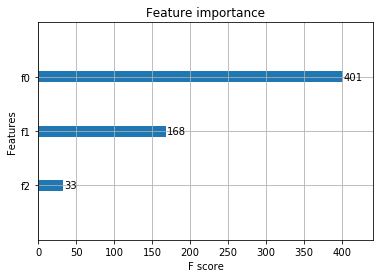

In [87]:
xgb.plot_importance(model4)

In [85]:
from scipy import stats
stats.describe(y_pred)

DescribeResult(nobs=120, minmax=(16.322754, 149.09167), mean=42.99929, variance=833.63605, skewness=2.0482797622680664, kurtosis=3.822330571840512)

In [86]:
r2_score(y_test, y_pred)

0.7154182726883911

In [94]:
df = pd.read_csv('Dane_bank.csv', sep=',')

In [95]:
df_copy = df.copy(deep = True)

In [96]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [102]:
x=df_copy.iloc[:,[3,6,11,10]]
x.head()

,CreditScore,Age,IsActiveMember,HasCrCard
0,619,42,1,1
1,608,41,1,0
2,502,42,0,1
3,699,39,0,0
4,850,43,1,1


In [103]:
x=x.rename(columns={'CreditScore':'f0','Age':'f1', 'HasCrCard':'f3', 'IsActiveMember':'f2'})
x.head()

,f0,f1,f2,f3
0,619,42,1,1
1,608,41,1,0
2,502,42,0,1
3,699,39,0,0
4,850,43,1,1


In [112]:
#df_copy['Salary_predict']=np.exp(model3.predict(x))*10000

In [48]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2.886896e+03,1.000000e+00,2.500750e+03,5.000500e+03,7.500250e+03,1.000000e+04
CustomerId,10000.0,1.569094e+07,7.193619e+04,1.556570e+07,1.562853e+07,1.569074e+07,1.575323e+07,1.581569e+07
CreditScore,10000.0,6.505288e+02,9.665330e+01,3.500000e+02,5.840000e+02,6.520000e+02,7.180000e+02,8.500000e+02
Age,10000.0,3.892180e+01,1.048781e+01,1.800000e+01,3.200000e+01,3.700000e+01,4.400000e+01,9.200000e+01
Tenure,10000.0,5.012800e+00,2.892174e+00,0.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00,1.000000e+01
Balance,10000.0,7.648589e+04,6.239741e+04,0.000000e+00,0.000000e+00,9.719854e+04,1.276442e+05,2.508981e+05
NumOfProducts,10000.0,1.530200e+00,5.816544e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
HasCrCard,10000.0,7.055000e-01,4.558405e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
IsActiveMember,10000.0,5.151000e-01,4.997969e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
EstimatedSalary,10000.0,1.000902e+05,5.751049e+04,1.158000e+01,5.100211e+04,1.001939e+05,1.493882e+05,1.999925e+05


In [43]:
%matplotlib qt

In [104]:
y_pred_bank=model4.predict(x)

In [106]:
stats.describe(y_pred_bank*10000)

DescribeResult(nobs=10000, minmax=(191477.9, 1730501.1), mean=1130141.1, variance=94773330000.0, skewness=-0.16907134652137756, kurtosis=-0.7815447163441611)

In [117]:
df_copy['Salary_pred2']=y_pred_bank*1000

In [118]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.000000e+00,2500.75,5.000500e+03,7.500250e+03,1.000000e+04
CustomerId,10000.0,1.569094e+07,71936.186123,1.556570e+07,15628528.25,1.569074e+07,1.575323e+07,1.581569e+07
CreditScore,10000.0,6.505288e+02,96.653299,3.500000e+02,584.00,6.520000e+02,7.180000e+02,8.500000e+02
Age,10000.0,3.892180e+01,10.487806,1.800000e+01,32.00,3.700000e+01,4.400000e+01,9.200000e+01
Tenure,10000.0,5.012800e+00,2.892174,0.000000e+00,3.00,5.000000e+00,7.000000e+00,1.000000e+01
Balance,10000.0,7.648589e+04,62397.405202,0.000000e+00,0.00,9.719854e+04,1.276442e+05,2.508981e+05
NumOfProducts,10000.0,1.530200e+00,0.581654,1.000000e+00,1.00,1.000000e+00,2.000000e+00,4.000000e+00
HasCrCard,10000.0,7.055000e-01,0.455840,0.000000e+00,0.00,1.000000e+00,1.000000e+00,1.000000e+00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.000000e+00,0.00,1.000000e+00,1.000000e+00,1.000000e+00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,1.158000e+01,51002.11,1.001939e+05,1.493882e+05,1.999925e+05


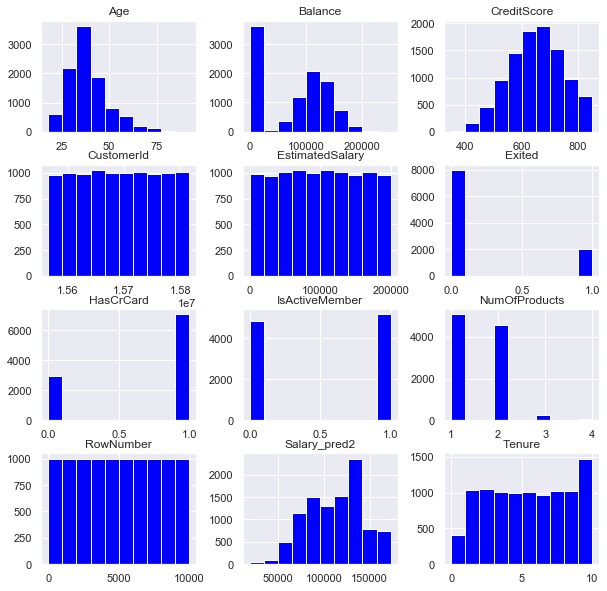

In [119]:
sns.set()
df_copy.hist(figsize=(10,10), color='blue')
plt.show()

In [121]:
df_copy['EstimatedSalary']=y_pred_bank*10000

In [124]:
df_copy=df_copy.drop('Salary_pred2', axis=1)

In [126]:
df_copy.to_csv(path_or_buf='Dane_bank_nowe.csv', sep=',')